# Distributed processing with `cabinetry` (+ `pyhf`)

This (as of AGC demo day #3) requires a custom branch of `cabinetry`:
```bash
pip install git+https://github.com/scikit-hep/cabinetry.git@feat/histogram-production-refactor
```


In [1]:
import logging
import glob
import shutil

import cabinetry
from dask.distributed import Client, LocalCluster, wait
import hist
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyhf


logging.basicConfig(format="%(levelname)s - %(name)s - %(message)s")
logging.getLogger("cabinetry").setLevel(logging.INFO)

shutil.rmtree("histograms", ignore_errors=True)


# import example config file
config = cabinetry.configuration.load("config_example.yml")
cabinetry.configuration.print_overview(config)

INFO - cabinetry.configuration - opening config file config_example.yml
INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   3 Sample(s)
INFO - cabinetry.configuration -   1 Regions(s)
INFO - cabinetry.configuration -   1 NormFactor(s)
INFO - cabinetry.configuration -   3 Systematic(s)


Specify whether you want to run locally or on coffea-casa.

In [2]:
# clocal setup
cluster = LocalCluster(n_workers=2)
client = Client(cluster)
print(f"Dask dashboard: {cluster.dashboard_link}")

# coffea-casa setup
# client = Client("tls://localhost:8786")

Dask dashboard: http://127.0.0.1:8787/status


## Template histogram production

In [3]:
!cat config config_example.yml

cat: config: No such file or directory
General:
  Measurement: "minimal_example"
  POI: "Signal_norm"
  HistogramFolder: "histograms/"
  InputPath: "inputs/{SamplePath}"

Regions:
  - Name: "Signal_region"
    Variable: "jet_pt"
    Filter: "lep_charge > 0"
    Binning: [200, 300, 400, 500, 600]

Samples:
  - Name: "Data"
    Tree: "pseudodata"
    SamplePath: "data.root"
    Data: True

  - Name: "Signal"
    Tree: "signal"
    SamplePath: "prediction.root"
    Weight: "weight"

  - Name: "Background"
    Tree: "background"
    SamplePath: "prediction.root"
    Weight: "weight"

Systematics:
  - Name: "Luminosity"
    Up:
      Normalization: 0.05
    Down:
      Normalization: -0.05
    Type: "Normalization"

  - Name: "Modeling"
    Up:
      SamplePath: "prediction.root"
      Tree: "background_varied"
    Down:
      Symmetrize: True
    Samples: "Background"
    Type: "NormPlusShape"

  - Name: "WeightBasedModeling"
    Up:
      Weight: "weight_up"
    Down:
      Weight: "0.7*w

The old, non-distributed way of template histogram production: `cabinetry` figures out which histograms are needed to build the model specified in the config and does all that behind the scenes.

(Side note: yes, there are better ways than saving every histogram into a `.npz` file — this should be improved.)

In [4]:
cabinetry.templates.build(config)
glob.glob("histograms/*")  # the histograms appear here

WARNING - cabinetry.histo - Signal_region_Signal has empty bins: [0]


['histograms/Signal_region_Background_WeightBasedModeling_Up.npz',
 'histograms/Signal_region_Background_Modeling_Up.npz',
 'histograms/Signal_region_Data.npz',
 'histograms/Signal_region_Signal.npz',
 'histograms/Signal_region_Background.npz',
 'histograms/Signal_region_Background_WeightBasedModeling_Down.npz']

The new API makes it more explicit what "work" exists and needs to be handled: it provides a list of instructions to build histograms (they still require translation into `uproot` + `awkward` Python code by `cabinetry`).

In [5]:
template_list = cabinetry.route.required_templates(config)

for template_instructions in template_list:
    print(f"{template_instructions}\n")

({'Name': 'Signal_region', 'Variable': 'jet_pt', 'Filter': 'lep_charge > 0', 'Binning': [200, 300, 400, 500, 600]}, {'Name': 'Data', 'Tree': 'pseudodata', 'SamplePath': 'data.root', 'Data': True}, {}, None)

({'Name': 'Signal_region', 'Variable': 'jet_pt', 'Filter': 'lep_charge > 0', 'Binning': [200, 300, 400, 500, 600]}, {'Name': 'Signal', 'Tree': 'signal', 'SamplePath': 'prediction.root', 'Weight': 'weight'}, {}, None)

({'Name': 'Signal_region', 'Variable': 'jet_pt', 'Filter': 'lep_charge > 0', 'Binning': [200, 300, 400, 500, 600]}, {'Name': 'Background', 'Tree': 'background', 'SamplePath': 'prediction.root', 'Weight': 'weight'}, {}, None)

({'Name': 'Signal_region', 'Variable': 'jet_pt', 'Filter': 'lep_charge > 0', 'Binning': [200, 300, 400, 500, 600]}, {'Name': 'Background', 'Tree': 'background', 'SamplePath': 'prediction.root', 'Weight': 'weight'}, {'Name': 'Modeling', 'Up': {'SamplePath': 'prediction.root', 'Tree': 'background_varied'}, 'Down': {'Symmetrize': True}, 'Samples': '

We can process these "instructions" one at a time (or in batches) by handing them over to `cabinetry`.

In [6]:
shutil.rmtree("histograms", ignore_errors=True)  # delete existing histograms again to reproduce them

cabinetry.templates.build(config, template_list=template_list[0:2])  # here we build the first two
cabinetry.templates.build(config, template_list=template_list[2:])  # and the rest

glob.glob("histograms/*")  # the histograms have been successfully recreated

WARNING - cabinetry.histo - Signal_region_Signal has empty bins: [0]


['histograms/Signal_region_Background_WeightBasedModeling_Up.npz',
 'histograms/Signal_region_Background_Modeling_Up.npz',
 'histograms/Signal_region_Data.npz',
 'histograms/Signal_region_Signal.npz',
 'histograms/Signal_region_Background_WeightBasedModeling_Down.npz']

## Using Dask instead

We could now send these instructions off via e.g. Python futures, or use Dask.

In [7]:
shutil.rmtree("histograms", ignore_errors=True)  # delete existing histograms again to reproduce them


def produce_single_template(template):
    cabinetry.templates.build(config, template_list=[template])


wait(client.map(produce_single_template, template_list))


glob.glob("histograms/*")  # the histograms have been successfully recreated

Signal_region_Signal has empty bins: [0]


['histograms/Signal_region_Background_WeightBasedModeling_Up.npz',
 'histograms/Signal_region_Background_Modeling_Up.npz',
 'histograms/Signal_region_Data.npz',
 'histograms/Signal_region_Signal.npz',
 'histograms/Signal_region_Background.npz',
 'histograms/Signal_region_Background_WeightBasedModeling_Down.npz']

This works fine locally. Note however the structure of `produce_single_template`: we are *not* producing a histogram on a worker and sending back that histogram over the network.
Instead, the histogram is saved wherever it is processed.



```
 node 1         | node 2..N
                |        read input
                |            v
__________      |         ___|____
|notebook| send work item |worker|
|________| -------------> |______|
                |            |
                |            V
                |       save histogram
```
This works fine with a shared file system.
At the moment, this would not run on coffea-casa.

We could instead go for a "coffea-like" approach and send the histogram back and save it on the head node:


```
 node 1         | node 2..N
                |        read input
                |            v
__________      |         ___|____
|notebook| send work item |worker|
|        | -------------> |      |
|        |  return hist   |      |
|________| <------------- |______|
    |           |
    v           |
 save histogram |
```

This should work fine, but require some internal refactoring in `cabinetry`.

### Discussion item

To what extent do we want to support shared file systems?
In the example here, users will need to ship around O(10k) 1-dimensional histograms, which is no big deal.
Not clear to me that this scales to ntuple-skimming jobs (which traditionally would be done on batch) and shipping around many O(10 GB) or larger files (memory + maybe network issues?).

## Statistical inference

In [8]:
# perform histogram post-processing
cabinetry.templates.postprocess(config)

# build a workspace and obtain statistical model + data to fit to
ws = cabinetry.workspace.build(config)
model, data = cabinetry.model_utils.model_and_data(ws)

WARNING - cabinetry.histo - Signal_region_Signal has empty bins: [0]
INFO - cabinetry.workspace - building workspace


A single fit can be done in a straightforward way:

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.19                      │              Nfcn = 327              │
│ EDM = 1.12e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

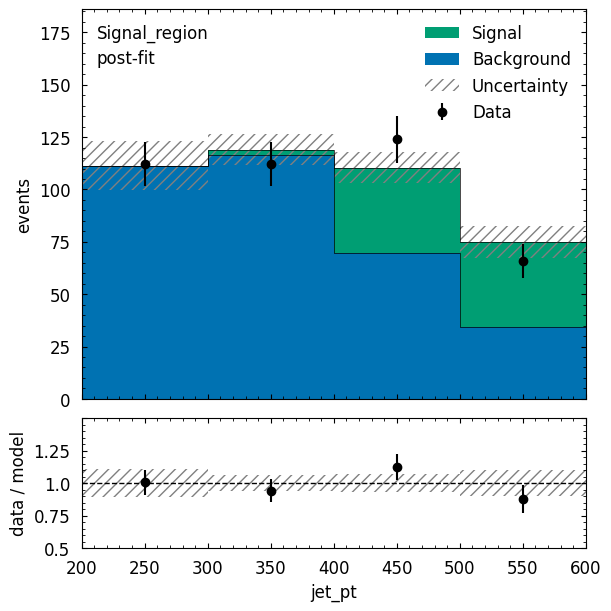

In [9]:
# run a fit
fit_results = cabinetry.fit.fit(model, data)

# visualize post-fit model prediction
prediction_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(prediction_postfit, data, config=config)

What if we want to run _many_ fits?
Example here: toy-based p-value distribution for goodness-of-fit.

In [10]:
logging.getLogger("cabinetry").setLevel(logging.ERROR)  # make cabinetry more quiet for this
pdf = model.make_pdf(pyhf.tensorlib.astensor(model.config.suggested_init()))

gof_values = []

def plot_histogram(gof_values):
    mpl.style.use("ggplot")
    fig, ax = plt.subplots()
    hist.new.Regular(20, 0, 1).Weight().fill(gof_values, weight=1/NTOYS*20).plot(linewidth=2)
    # ax_1.hist(gof_values, bins=np.linspace(0, 1, 11), density=True)
    ax.set_xlabel("goodness-of-fit $p$-value")

Run fits to 100 toys and visualize the p-value distribution.

CPU times: user 4.1 s, sys: 655 ms, total: 4.75 s
Wall time: 4.38 s


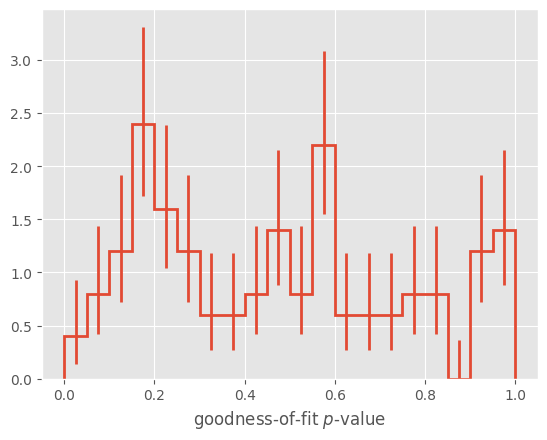

In [11]:
%%time

NTOYS = 100
samples = pdf.sample((NTOYS,))

# run a fit for each toy MC
for sample in samples:
    fit_result = cabinetry.fit.fit(model, sample, goodness_of_fit=True)
    gof_values.append(fit_result.goodness_of_fit)

plot_histogram(gof_values)

If we want more toys, we should parallelize.
Dask comes to the rescue!

CPU times: user 2.81 s, sys: 574 ms, total: 3.38 s
Wall time: 36.2 s


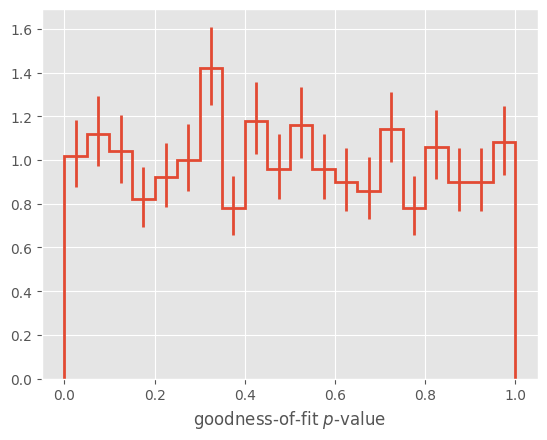

In [12]:
%%time

NTOYS = 1_000
samples = pdf.sample((NTOYS,))

# returns our workload, which is a function that calculates a goodness-of-fit p-value given some toy dataset
# NB: the outer function can probably be avoided with better use of the Dask API (?) -> suggestions welcome!
def get_fit_function(model):
    def get_gof(sample):
        try:
            fit_result = cabinetry.fit.fit(model, sample, goodness_of_fit=True)
            gof = fit_result.goodness_of_fit
        except pyhf.exceptions.FailedMinimization:  # also handle minimization failures
            gof = np.nan
        return gof
    return get_gof


# toys via Dask
scattered_data = client.scatter([s for s in samples])  # instead of submitting (possibly big) object directly
futures = client.map(get_fit_function(model), scattered_data)
gof_values = np.asarray([r for r in client.gather(iter(futures))])  # collect our results
    
plot_histogram(gof_values)

You can also use the same pattern with e.g. Python futures instead.

In [13]:
client.close()
cluster.close()

W FCN result is NaN for [ 2.20287 1.66837 1.4037 -3.77396 0.735189 0.991798 0.746009 1.07237 ]
W FCN result is NaN for [ nan nan nan nan nan nan nan nan ]
W FCN result is NaN for [ nan nan nan nan nan nan nan nan ]
W FCN result is NaN for [ nan nan nan nan nan nan nan nan ]
W FCN result is NaN for [ nan nan nan nan nan nan nan nan ]
W FCN result is NaN for [ nan nan nan nan nan nan nan nan ]
W FCN result is NaN for [ nan nan nan nan nan nan nan nan ]
W FCN result is NaN for [ nan nan nan nan nan nan nan nan ]
W FCN result is NaN for [ nan nan nan nan nan nan nan nan ]
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 34908.9 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -0.0022493
W MnPosDef non-positive diagonal element in covariance matrix[ 1 ] = -3.95667
W MnPosDef non-positive diagonal element in covariance matrix[ 3 ] = -0.000599328
W MnPosDef non-positive diagonal element